## Predict 2 meter temperature with sea surface temperature using LSTM
This notebook serves as an example of a basic workflow of data driven forecasting using deep learning with `s2spy` & `lilio` packages. <br>
We will predict temperature in US at seasonal time scales using ERA5 dataset with LSTM network. <br>

This recipe includes the following steps:
- Define a calendar (`lilio`)
- Download/load input data (`era5cli`) (TBA)
- Map the calendar to the data (`lilio`)
- Train-validate-test split (60%/20%/20%) (`torch`)
- Preprocessing based on the training set (`s2spy`)
- Resample data to the calendar (`lilio`)
- Create LSTM model (`torch`)
- Specify hyper-parameters (`wandb`)
- Train model (`torch`)
- Evaludate model

In [1]:
import lilio
import numpy as np
import time as tt
import wandb
import xarray as xr
from pathlib import Path
from s2spy import preprocess
import torch
from torch import nn
from torch.autograd import Variable

#### Define a calendar with `lilio` to specify time range for targets and precursors.

In [2]:
# create custom calendar based on the time of interest
calendar = lilio.Calendar(anchor="08-01", allow_overlap=True)
# add target periods
calendar.add_intervals("target", length="30d")
# add precursor periods
periods_of_interest = 8
for _ in range(periods_of_interest):
    calendar.add_intervals("precursor", "1M", gap="1M")

In [3]:
# check calendar
calendar

Calendar(
    anchor='08-01',
    allow_overlap=False,
    mapping=None,
    intervals=[
        Interval(role='target', length='30d', gap='0d'),
        Interval(role='precursor', length='1M', gap='1M'),
        Interval(role='precursor', length='1M', gap='1M'),
        Interval(role='precursor', length='1M', gap='1M'),
        Interval(role='precursor', length='1M', gap='1M'),
        Interval(role='precursor', length='1M', gap='1M'),
        Interval(role='precursor', length='1M', gap='1M'),
        Interval(role='precursor', length='1M', gap='1M'),
        Interval(role='precursor', length='1M', gap='1M')
    ]
)

#### Download SST and T2M from ERA5 using `era5cli` and prepare input data
(This step will be added later. We skip this step for now and use the data we already have.)

In [ ]:
# before executing the fetch request, make sure that you have your ID and key
# check this doc if not https://era5cli.readthedocs.io/en/latest/instructions.html#register-at-copernicus-climate-data-service
# download land variables
#!era5cli hourly --variables 2m_temperature sea_surface_temperature volumetric_soil_water_layer_1 --startyear 2000 --endyear 2010 --area 50 175 35 240

In [4]:
# load data
data_folder = '~/AI4S2S/data'
precursor_field = xr.open_dataset(Path(data_folder, 'sst_daily_1979-2018_5deg_Pacific_175_240E_25_50N.nc'))
target_field = xr.open_dataset(Path(data_folder,'tf5_nc5_dendo_80d77.nc'))

#### Map the calendar to the data
After mapping the calendar to the field, we can visualize our calendar by calling the `visualize` method.

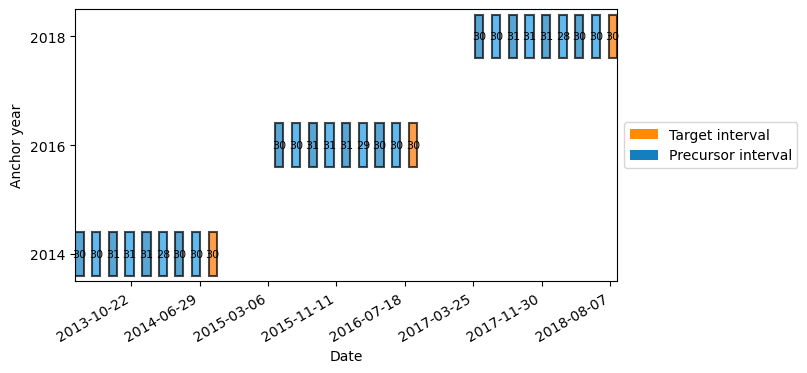

In [5]:
# map calendar to data
calendar.map_to_data(precursor_field)
calendar.visualize(show_length=True)

Also, we can get a list of all intervals by running the following line. There, you will find the intervals `-1` and `1`, which corresponds to the creation of a precursor interval (negative integer(s)) and a target interval (positive integer(s)), respectively. <br>

For more information about the definition of intervals, and how `lilio` works, please check the [README](https://github.com/AI4S2S/lilio) of `lilio`.

In [6]:
calendar.show()[:3]

i_interval,-8,-7,-6,-5,-4,-3,-2,-1,1
anchor_year,,,,,,,,,
2018,"[2017-04-01, 2017-05-01)","[2017-06-01, 2017-07-01)","[2017-08-01, 2017-09-01)","[2017-10-01, 2017-11-01)","[2017-12-01, 2018-01-01)","[2018-02-01, 2018-03-01)","[2018-04-01, 2018-05-01)","[2018-06-01, 2018-07-01)","[2018-08-01, 2018-08-31)"
2016,"[2015-04-01, 2015-05-01)","[2015-06-01, 2015-07-01)","[2015-08-01, 2015-09-01)","[2015-10-01, 2015-11-01)","[2015-12-01, 2016-01-01)","[2016-02-01, 2016-03-01)","[2016-04-01, 2016-05-01)","[2016-06-01, 2016-07-01)","[2016-08-01, 2016-08-31)"
2014,"[2013-04-01, 2013-05-01)","[2013-06-01, 2013-07-01)","[2013-08-01, 2013-09-01)","[2013-10-01, 2013-11-01)","[2013-12-01, 2014-01-01)","[2014-02-01, 2014-03-01)","[2014-04-01, 2014-05-01)","[2014-06-01, 2014-07-01)","[2014-08-01, 2014-08-31)"


#### Train-validate-test split based on the anchor years (60%/20%/20% split)

In [7]:
# get 60% of instance as training
years = sorted(calendar.get_intervals().index)
train_samples = round(len(years) * 0.6)
test_samples = round(len(years) * 0.2)
start_year = years[0]

#### Fit preprocessor with training samples and preprocess data
In this step, we remove trend and take anomalies for the precursor field. Note that here we use raw daily data for detrending and taking anomalies. <br>

In general, there are many "flavors" of preprocessing, like when to perform this operation, and in which order do we want to preprocess the data. To improve the transparency and reproducibility of our work, we think it is necessary to standardize these steps. To stick to the best practices, we suggest to preprocess your data in the following way.

In [8]:
# create preprocessor
preprocessor = preprocess.Preprocessor(
    rolling_window_size=25,
    detrend="linear",
    subtract_climatology=True,
)

# fit preprocessor with training data
preprocessor.fit(precursor_field.sel(time=slice(str(start_year),
                                                str(start_year + train_samples - 1))))

In [9]:
# preprocess the whole precursor field
precursor_field_prep = preprocessor.transform(precursor_field)

#### Resample data to the calendar

In [10]:
precursor_field_resample = lilio.resample(calendar, precursor_field_prep)
target_field_resample = lilio.resample(calendar, target_field)

In [11]:
# select variables and intervals
precursor_field_sel = precursor_field_resample['sst']
target_series_sel = target_field_resample['ts'].sel(cluster=3)

We need to convert our data to `torch.Tensor`.

In [12]:
# slice and reshape input desired by transformer
sequence_precursor = len(precursor_field_sel.i_interval) - 1 # we only take precursor parts of i intervals
lat_precursor = len(precursor_field_sel.latitude)
lon_precursor = len(precursor_field_sel.longitude)

X_torch = torch.from_numpy(precursor_field_sel[:,:-1,:,:].data).type(torch.FloatTensor)
y_torch = torch.from_numpy(target_series_sel[:,-1].data).type(torch.FloatTensor)

X_torch = X_torch.view(-1, sequence_precursor, lat_precursor*lon_precursor)

# turn nan to 0.0
X_torch = torch.nan_to_num(X_torch, 0.0)

We split our data into train/cross-validate/test sets.

In [13]:
# train/validate/test split and use pytorch dataloader
train_X_torch = X_torch[:train_samples]
train_y_torch = y_torch[:train_samples]

valid_X_torch = X_torch[train_samples:train_samples + test_samples]
valid_y_torch = y_torch[train_samples:train_samples + test_samples]

test_X_torch = X_torch[-test_samples:]
test_y_torch = y_torch[-test_samples:]

# pytorch train and test sets
train_set = torch.utils.data.TensorDataset(train_X_torch, train_y_torch)
valid_set = torch.utils.data.TensorDataset(valid_X_torch, valid_y_torch)
test_set = torch.utils.data.TensorDataset(test_X_torch, test_y_torch)

#### Build LSTM model
Build a LSTM model with `nn.LSTM` module.

In [14]:
class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim=1,
                 batch_size=1, num_layers=1):
        """
        Initialize the LSTM model in Pytorch and specify the basic model structure.
        Expected input timeseries dimension [batch_size, sequence, channels]
        """
        super().__init__()
        self.hidden_dim = hidden_dim
        self.batch_size = batch_size
        self.num_layers = num_layers
        # Define the LSTM layer
        self.lstm = nn.LSTM(input_size = input_dim, hidden_size = hidden_dim,
                            num_layers = num_layers, batch_first = True)

        # Define the output layer
        self.linear = nn.Linear(hidden_dim, output_dim)
        
    def init_hidden(self):
        """Initialize hidden state with random values."""
        return (torch.randn(self.num_layers, self.batch_size, self.hidden_dim),
                torch.randn(self.num_layers, self.batch_size, self.hidden_dim))
        
    def forward(self, input):
        (h_0, c_0) = self.init_hidden()
        x, _ = self.lstm(input, (h_0, c_0))
        x = self.linear(x)
            
        return x

#### Hyper-parameter tuning with W&B
We use Weight&Biases to monitor the training process. It is very simple to integrate it into our workflow and more information about how to set it up can be found at https://docs.wandb.ai/quickstart. <br>

Print system info.

In [15]:
print ("Pytorch version {}".format(torch.__version__))
use_cuda = torch.cuda.is_available()
print("Is CUDA available? {}".format(use_cuda))
# use GPU if possible
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Device to be used for computation: {}".format(device))

Pytorch version 1.12.1
Is CUDA available? False
Device to be used for computation: cpu


Define hyperparameters, initialize config for wandb and syncronize training information with W&B server.

In [16]:
# call weights & biases service
wandb.login()

# define hyperparameters and the 
hyperparameters = dict(
    epoch = 50,
    input_dim = lat_precursor*lon_precursor,
    hidden_dim = lat_precursor*lon_precursor*4,
    output_dim = 1,
    batch_size = 4, 
    num_layers = 4,
    learning_rate = 0.01,
    dataset = 'Weather',
    architecture = 'LSTM'
)

# initialize weights & biases service
mode = 'online'
#mode = 'disabled'
wandb.init(config=hyperparameters, project='test-LSTM', entity='ai4s2s', mode=mode)
config = wandb.config

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: git-yang (ai4s2s). Use `wandb login --relogin` to force relogin


Create data loaders with chosen batch size. 

In [17]:
# create data loader and use batch 
train_loader = torch.utils.data.DataLoader(train_set, batch_size = config.batch_size, shuffle = False)
valid_loader = torch.utils.data.DataLoader(valid_set, batch_size = config.batch_size, shuffle = False)
test_loader = torch.utils.data.DataLoader(test_set, batch_size = config.batch_size, shuffle = False)

#### Initialize and train model
Create model using specified hyperparameter. Initialize model and choose loss function and optimizer.

In [18]:
# Initialize model
model = LSTM(input_dim = config["input_dim"],
             hidden_dim = config["hidden_dim"],
             output_dim = config["output_dim"], 
             batch_size = config["batch_size"], 
             num_layers = config["num_layers"]
)
# Specify loss function
criterion = nn.MSELoss()
# Choose optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=config.learning_rate)
# Print model and optimizer details
print('Model details:\n', model)
print('Optimizer details:\n',optimizer)
wandb.watch(model)

Model details:
 LSTM(
  (lstm): LSTM(65, 260, num_layers=4, batch_first=True)
  (linear): Linear(in_features=260, out_features=1, bias=True)
)
Optimizer details:
 Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    eps: 1e-08
    foreach: None
    lr: 0.01
    maximize: False
    weight_decay: 0
)


[]

Start the training and cross validation loop.

In [19]:
# calculate the time for the code execution
start_time = tt.time()

# switch model into training mode
model.train()

hist_train = []
hist_valid = []
for epoch in range(config.epoch):
    # training loop
    # switch model into train mode
    model.train()
    hist_train_step = 0
    for batch_idx, (X_batch, y_batch) in enumerate(train_loader):
        var_X_batch = Variable(X_batch).to(device)
        var_y_batch = Variable(y_batch).to(device)
        optimizer.zero_grad()
        # note: decoder input is the last instance of encoder input
        output = model(var_X_batch)
        loss = criterion(output[:,-1,:].squeeze(), var_y_batch) # we only need the last instance from output sequence
        loss.backward()
        optimizer.step()
        wandb.log({'train_loss': loss.item()})
        print(f'Epoch : {epoch} [{batch_idx*len(X_batch)}/{len(train_loader.dataset)}'
              f'({100.* batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item():.6f}')
        hist_train_step += loss.item()

    hist_train.append(hist_train_step / len(train_loader.dataset))

    # cross-validation loop
    # switch model into evaluation mode
    model.eval()
    hist_valid_step = 0

    for batch_idx, (X_batch, y_batch) in enumerate(valid_loader):
        var_X_batch = Variable(X_batch).to(device)
        var_y_batch = Variable(y_batch).to(device)
        optimizer.zero_grad()
        with torch.no_grad():
            output = model(var_X_batch)
            loss = criterion(output[:,-1,:].squeeze(), var_y_batch)
        wandb.log({'validation_loss': loss.item()})
        hist_valid_step += loss.item()

    hist_valid.append(hist_valid_step / len(valid_loader.dataset))

print (f"--- {(tt.time() - start_time)/60} minutes ---")

Epoch : 0 [0/12(0%)]	Loss: 2.407856
Epoch : 0 [4/12(33%)]	Loss: 4.017538
Epoch : 0 [8/12(67%)]	Loss: 1.024974
Epoch : 1 [0/12(0%)]	Loss: 4.246447
Epoch : 1 [4/12(33%)]	Loss: 5.489901
Epoch : 1 [8/12(67%)]	Loss: 1.267457
Epoch : 2 [0/12(0%)]	Loss: 1.715001
Epoch : 2 [4/12(33%)]	Loss: 1.780857
Epoch : 2 [8/12(67%)]	Loss: 1.933752
Epoch : 3 [0/12(0%)]	Loss: 4.285742
Epoch : 3 [4/12(33%)]	Loss: 1.655711
Epoch : 3 [8/12(67%)]	Loss: 0.741834
Epoch : 4 [0/12(0%)]	Loss: 0.794180
Epoch : 4 [4/12(33%)]	Loss: 2.046580
Epoch : 4 [8/12(67%)]	Loss: 0.671073
Epoch : 5 [0/12(0%)]	Loss: 1.586237
Epoch : 5 [4/12(33%)]	Loss: 2.308794
Epoch : 5 [8/12(67%)]	Loss: 1.062453
Epoch : 6 [0/12(0%)]	Loss: 0.530034
Epoch : 6 [4/12(33%)]	Loss: 2.000674
Epoch : 6 [8/12(67%)]	Loss: 0.063749
Epoch : 7 [0/12(0%)]	Loss: 1.298124
Epoch : 7 [4/12(33%)]	Loss: 1.315361
Epoch : 7 [8/12(67%)]	Loss: 1.796358
Epoch : 8 [0/12(0%)]	Loss: 0.365009
Epoch : 8 [4/12(33%)]	Loss: 1.193497
Epoch : 8 [8/12(67%)]	Loss: 1.076562
Epoch : 9 

Now let's check the training loss and validation loss.

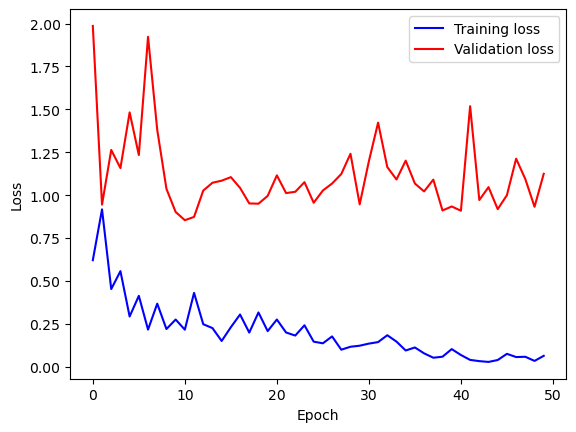

In [20]:
import matplotlib.pyplot as plt
fig = plt.figure()
plt.plot(np.asarray(hist_train), 'b', label="Training loss")
plt.plot(np.asarray(hist_valid), 'r', label="Validation loss")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [21]:
# save the checkpoint model training if necessary
output_path = "../models/"

torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss.item()
            }, Path(output_path,'lstm_train_checkpoint.pt'))

#### Evaluate model
Now we can evaluate our model with testing set and compare the predictions with the ground truth.

In [22]:
# switch model into evaluation mode
model.eval()
hist_test = []
predictions = []
hist_test_step = 0
for batch_idx, (X_batch, y_batch) in enumerate(test_loader):
    var_X_batch = Variable(X_batch).to(device)
    var_y_batch = Variable(y_batch).to(device)
    optimizer.zero_grad()
    with torch.no_grad():
        output = model(var_X_batch)
        loss = criterion(output[:,-1,:].squeeze(), var_y_batch)
    wandb.log({'testing_loss': loss.item()})
    predictions.append(output.squeeze().cpu().detach().numpy()[:,-1])
    hist_test_step += loss.item()

hist_test.append(hist_test_step / len(test_loader.dataset))
# call wandb finish to stop logging
wandb.finish()

testing_loss,▁
train_loss,██▄▂▄▄▄▂▃▆▃▃▂▅▂▂▄▂▁▃▁▃▂▁▃▂▁▂▂▁▁▃▁▁▁▁▁▁▂▁
validation_loss,█▂▄▃▃█▄▂▁▁▂▂▃▂▂▂▃▂▂▂▂▂▃▃▃▅▃▂▂▂▂▁▁▅▂▂▂▃▂▃
testing_loss,0.36668
train_loss,0.01809
validation_loss,4.49722


Plot the predictions versus ground truth.

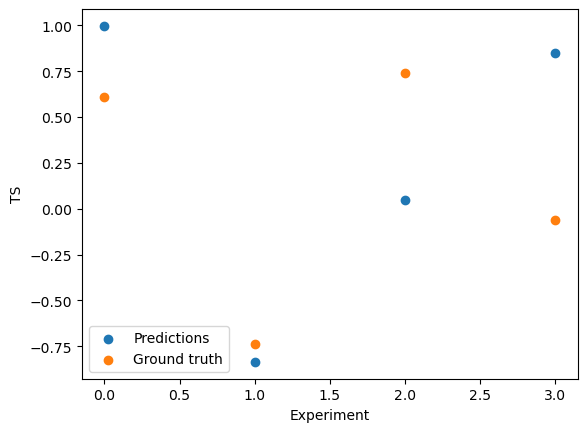

In [33]:
fig = plt.figure()
instances = np.arange(len(predictions[0]))
plt.scatter(instances, predictions[0], label="Predictions")
plt.scatter(instances, test_y_torch.squeeze().numpy(), label="Ground truth")
plt.xlabel("Experiment")
plt.ylabel("TS")
plt.legend()
plt.show()